In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import importlib

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
from tools import NMD as nmd
import tools.util_plot as nmd_plot



import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_embedding_grid(embeddings, hue=None, title_prefix="", sample_fraction=1.0):
    """
    Plots a grid of scatterplots for all pairwise combinations of embeddings.

    :param embeddings: NumPy array of shape (n_samples, n_features)
    :param hue: Series or list of hue values for coloring points based on clustering
    :param title_prefix: Optional prefix for the plot titles
    """
    # Convert embeddings to a DataFrame
    df_embeddings = pd.DataFrame(embeddings)
    
    df_embeddings = df_embeddings.sample(frac=sample_fraction, axis=0)
    

    if hue is None:
        g = sns.pairplot(df_embeddings, plot_kws={"s": 20, "alpha": 0.3})
    else:
        df_embeddings['Cluster'] = list(hue)
        g = sns.pairplot(df_embeddings, hue='Cluster', plot_kws={"s": 20, "alpha": 0.3})
    
    # Set titles for each subplot
    for i in range(df_embeddings.shape[1] - 1):
        for j in range(i + 1, df_embeddings.shape[1] - 1):
            # g.axes[j, i].set_title(f"{title_prefix}: Dim {i+1} vs Dim {j+1}")
            g.axes[j, i].set_xlabel(f"Embedding Dim {i+1}")
            g.axes[j, i].set_ylabel(f"Embedding Dim {j+1}")

    plt.show()

## Simulate ground-truth

In [3]:
def generate_nonnegative_matrix(m: int, n: int, r: int, c: float = 0.0):
    """Generates a (m, n) matrix X with rank r

    X is generated as min(0, W1@H1), where W1 is of size (m, r)
    and H1 of size (r, n), entries in W1 and H1 are standard normal, therefore,
    on average, 50% of the entries of X are zero if c == 0

    Args:
        m (int): Number of rows in X
        n (int): Number of columns in X
        r (int): Desired rank
        c (float): sparsity parameter 0 <= c <= 1.7

    Returns:
        np.ndarray: A matrix of shape (m, n) with non-negative entries.
    """
    W = np.random.randn(m, r) - c
    H = np.random.randn(r, n) + c
    return W @ H


def get_sparsity(X) -> float:
    """Computes the sparsity of a matrix X

    Args:
        X (np.ndarray): A matrix

    Returns:
        float: The sparsity of X
    """
    return 1.0 - np.count_nonzero(X) / X.size

In [4]:
n = 1000
p = 5000
k = 32

In [5]:
Theta = generate_nonnegative_matrix(n, p, k, c=0.5)
X = np.maximum(0, Theta)
get_sparsity(X)

0.8821532

## NMD-3b: rank correctly specified

In [6]:
from tools import NMD as nmd

In [7]:
k_exact = k
k_toolow = 10
k_toohigh = 20
k_waytoolow = 3

In [8]:
W0_exact, H0_exact = cs.nuclear_norm_init(X, n, p, k_exact)

In [9]:
Theta_3b_exact, W_3b_exact, H_3b_exact, loss_3b_exact, iters_3b_exact, times_3b_exact = nmd.nmd_3b(X, r=k_exact, W0=W0_exact, H0=H0_exact, beta1=0.7, max_iters=k_exact*100, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 46.772551] - 0.230832 secs
[1 : 37.490217] - 0.229042 secs
[2 : 32.119830] - 0.229657 secs
[3 : 29.078655] - 0.229696 secs
[4 : 27.198607] - 0.226341 secs
[5 : 25.948389] - 0.227194 secs
[6 : 25.006229] - 0.239929 secs
[7 : 24.232590] - 0.232868 secs
[8 : 23.551856] - 0.229231 secs
[9 : 22.852425] - 0.229624 secs
[10 : 22.063620] - 0.228886 secs
[11 : 21.142110] - 0.228750 secs
[12 : 20.134967] - 0.228847 secs
[13 : 19.163246] - 0.228669 secs
[14 : 18.317554] - 0.226837 secs
[15 : 17.608497] - 0.228367 secs
[16 : 17.007819] - 0.230893 secs
[17 : 16.485596] - 0.229249 secs
[18 : 16.020423] - 0.230940 secs
[19 : 15.598649] - 0.230193 secs
[20 : 15.211439] - 0.230071 secs
[21 : 14.852763] - 0.235423 secs
[22 : 14.518270] - 0.229099 secs
[23 : 14.204673] - 0.226877 secs
[24 : 13.909409] - 0.226795 secs
[25 : 13.630416] - 0.229177 secs
[26 : 13.366006] - 0.229015 secs
[27 : 13.114774] - 0.231028 

[248 : 2.951008] - 0.229480 secs
[249 : 2.940299] - 0.231100 secs
[250 : 2.929658] - 0.230471 secs
[251 : 2.919085] - 0.233323 secs
[252 : 2.908579] - 0.230494 secs
[253 : 2.898139] - 0.233652 secs
[254 : 2.887764] - 0.230737 secs
[255 : 2.877455] - 0.228559 secs
[256 : 2.867209] - 0.229427 secs
[257 : 2.857028] - 0.229646 secs
[258 : 2.846909] - 0.229030 secs
[259 : 2.836853] - 0.228110 secs
[260 : 2.826859] - 0.229247 secs
[261 : 2.816926] - 0.228702 secs
[262 : 2.807054] - 0.231481 secs
[263 : 2.797242] - 0.240122 secs
[264 : 2.787489] - 0.227733 secs
[265 : 2.777796] - 0.228463 secs
[266 : 2.768161] - 0.228252 secs
[267 : 2.758584] - 0.231811 secs
[268 : 2.749065] - 0.228736 secs
[269 : 2.739602] - 0.232626 secs
[270 : 2.730196] - 0.229719 secs
[271 : 2.720846] - 0.227278 secs
[272 : 2.711551] - 0.228229 secs
[273 : 2.702312] - 0.228887 secs
[274 : 2.693126] - 0.230081 secs
[275 : 2.683995] - 0.227489 secs
[276 : 2.674917] - 0.228780 secs
[277 : 2.665892] - 0.228770 secs
[278 : 2.6

[497 : 1.459898] - 0.234024 secs
[498 : 1.456575] - 0.233466 secs
[499 : 1.453264] - 0.232414 secs
[500 : 1.449965] - 0.233824 secs
[501 : 1.446678] - 0.232736 secs
[502 : 1.443402] - 0.232110 secs
[503 : 1.440139] - 0.231886 secs
[504 : 1.436887] - 0.233683 secs
[505 : 1.433646] - 0.233986 secs
[506 : 1.430418] - 0.233966 secs
[507 : 1.427200] - 0.234010 secs
[508 : 1.423994] - 0.235312 secs
[509 : 1.420800] - 0.233507 secs
[510 : 1.417616] - 0.232792 secs
[511 : 1.414444] - 0.233670 secs
[512 : 1.411284] - 0.236008 secs
[513 : 1.408134] - 0.233026 secs
[514 : 1.404996] - 0.236087 secs
[515 : 1.401868] - 0.236546 secs
[516 : 1.398752] - 0.237096 secs
[517 : 1.395646] - 0.233694 secs
[518 : 1.392552] - 0.239158 secs
[519 : 1.389468] - 0.238326 secs
[520 : 1.386395] - 0.241898 secs
[521 : 1.383333] - 0.237292 secs
[522 : 1.380281] - 0.234288 secs
[523 : 1.377240] - 0.234685 secs
[524 : 1.374210] - 0.234717 secs
[525 : 1.371190] - 0.233992 secs
[526 : 1.368180] - 0.235389 secs
[527 : 1.3

[746 : 0.892292] - 0.230882 secs
[747 : 0.890747] - 0.229475 secs
[748 : 0.889205] - 0.229130 secs
[749 : 0.887668] - 0.229613 secs
[750 : 0.886135] - 0.228913 secs
[751 : 0.884606] - 0.227976 secs
[752 : 0.883081] - 0.226619 secs
[753 : 0.881560] - 0.229612 secs
[754 : 0.880043] - 0.229486 secs
[755 : 0.878530] - 0.228229 secs
[756 : 0.877021] - 0.229879 secs
[757 : 0.875516] - 0.230499 secs
[758 : 0.874015] - 0.231839 secs
[759 : 0.872518] - 0.229315 secs
[760 : 0.871024] - 0.228920 secs
[761 : 0.869535] - 0.226421 secs
[762 : 0.868049] - 0.228588 secs
[763 : 0.866568] - 0.228489 secs
[764 : 0.865090] - 0.228784 secs
[765 : 0.863616] - 0.229001 secs
[766 : 0.862146] - 0.230597 secs
[767 : 0.860680] - 0.228829 secs
[768 : 0.859217] - 0.228567 secs
[769 : 0.857758] - 0.229247 secs
[770 : 0.856303] - 0.228348 secs
[771 : 0.854852] - 0.228561 secs
[772 : 0.853405] - 0.228875 secs
[773 : 0.851961] - 0.228861 secs
[774 : 0.850521] - 0.229129 secs
[775 : 0.849085] - 0.229371 secs
[776 : 0.8

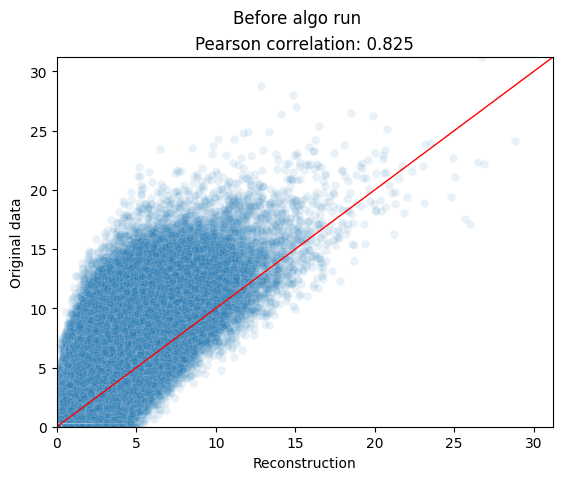

In [10]:
nmd_plot.plot_reconstruction(np.maximum(0, W0_exact@H0_exact), X, "Before algo run", type="scatter", sample_fraction=None)

In [11]:
kendalltau(np.maximum(0, W0_exact@H0_exact).flatten().round(0), X.flatten())

SignificanceResult(statistic=0.6750828735142552, pvalue=0.0)

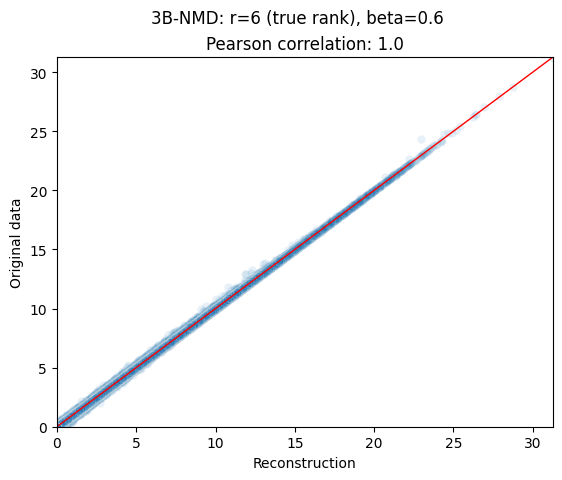

In [12]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b_exact), X, "3B-NMD: r=6 (true rank), beta=0.6", type="scatter", sample_fraction=None)

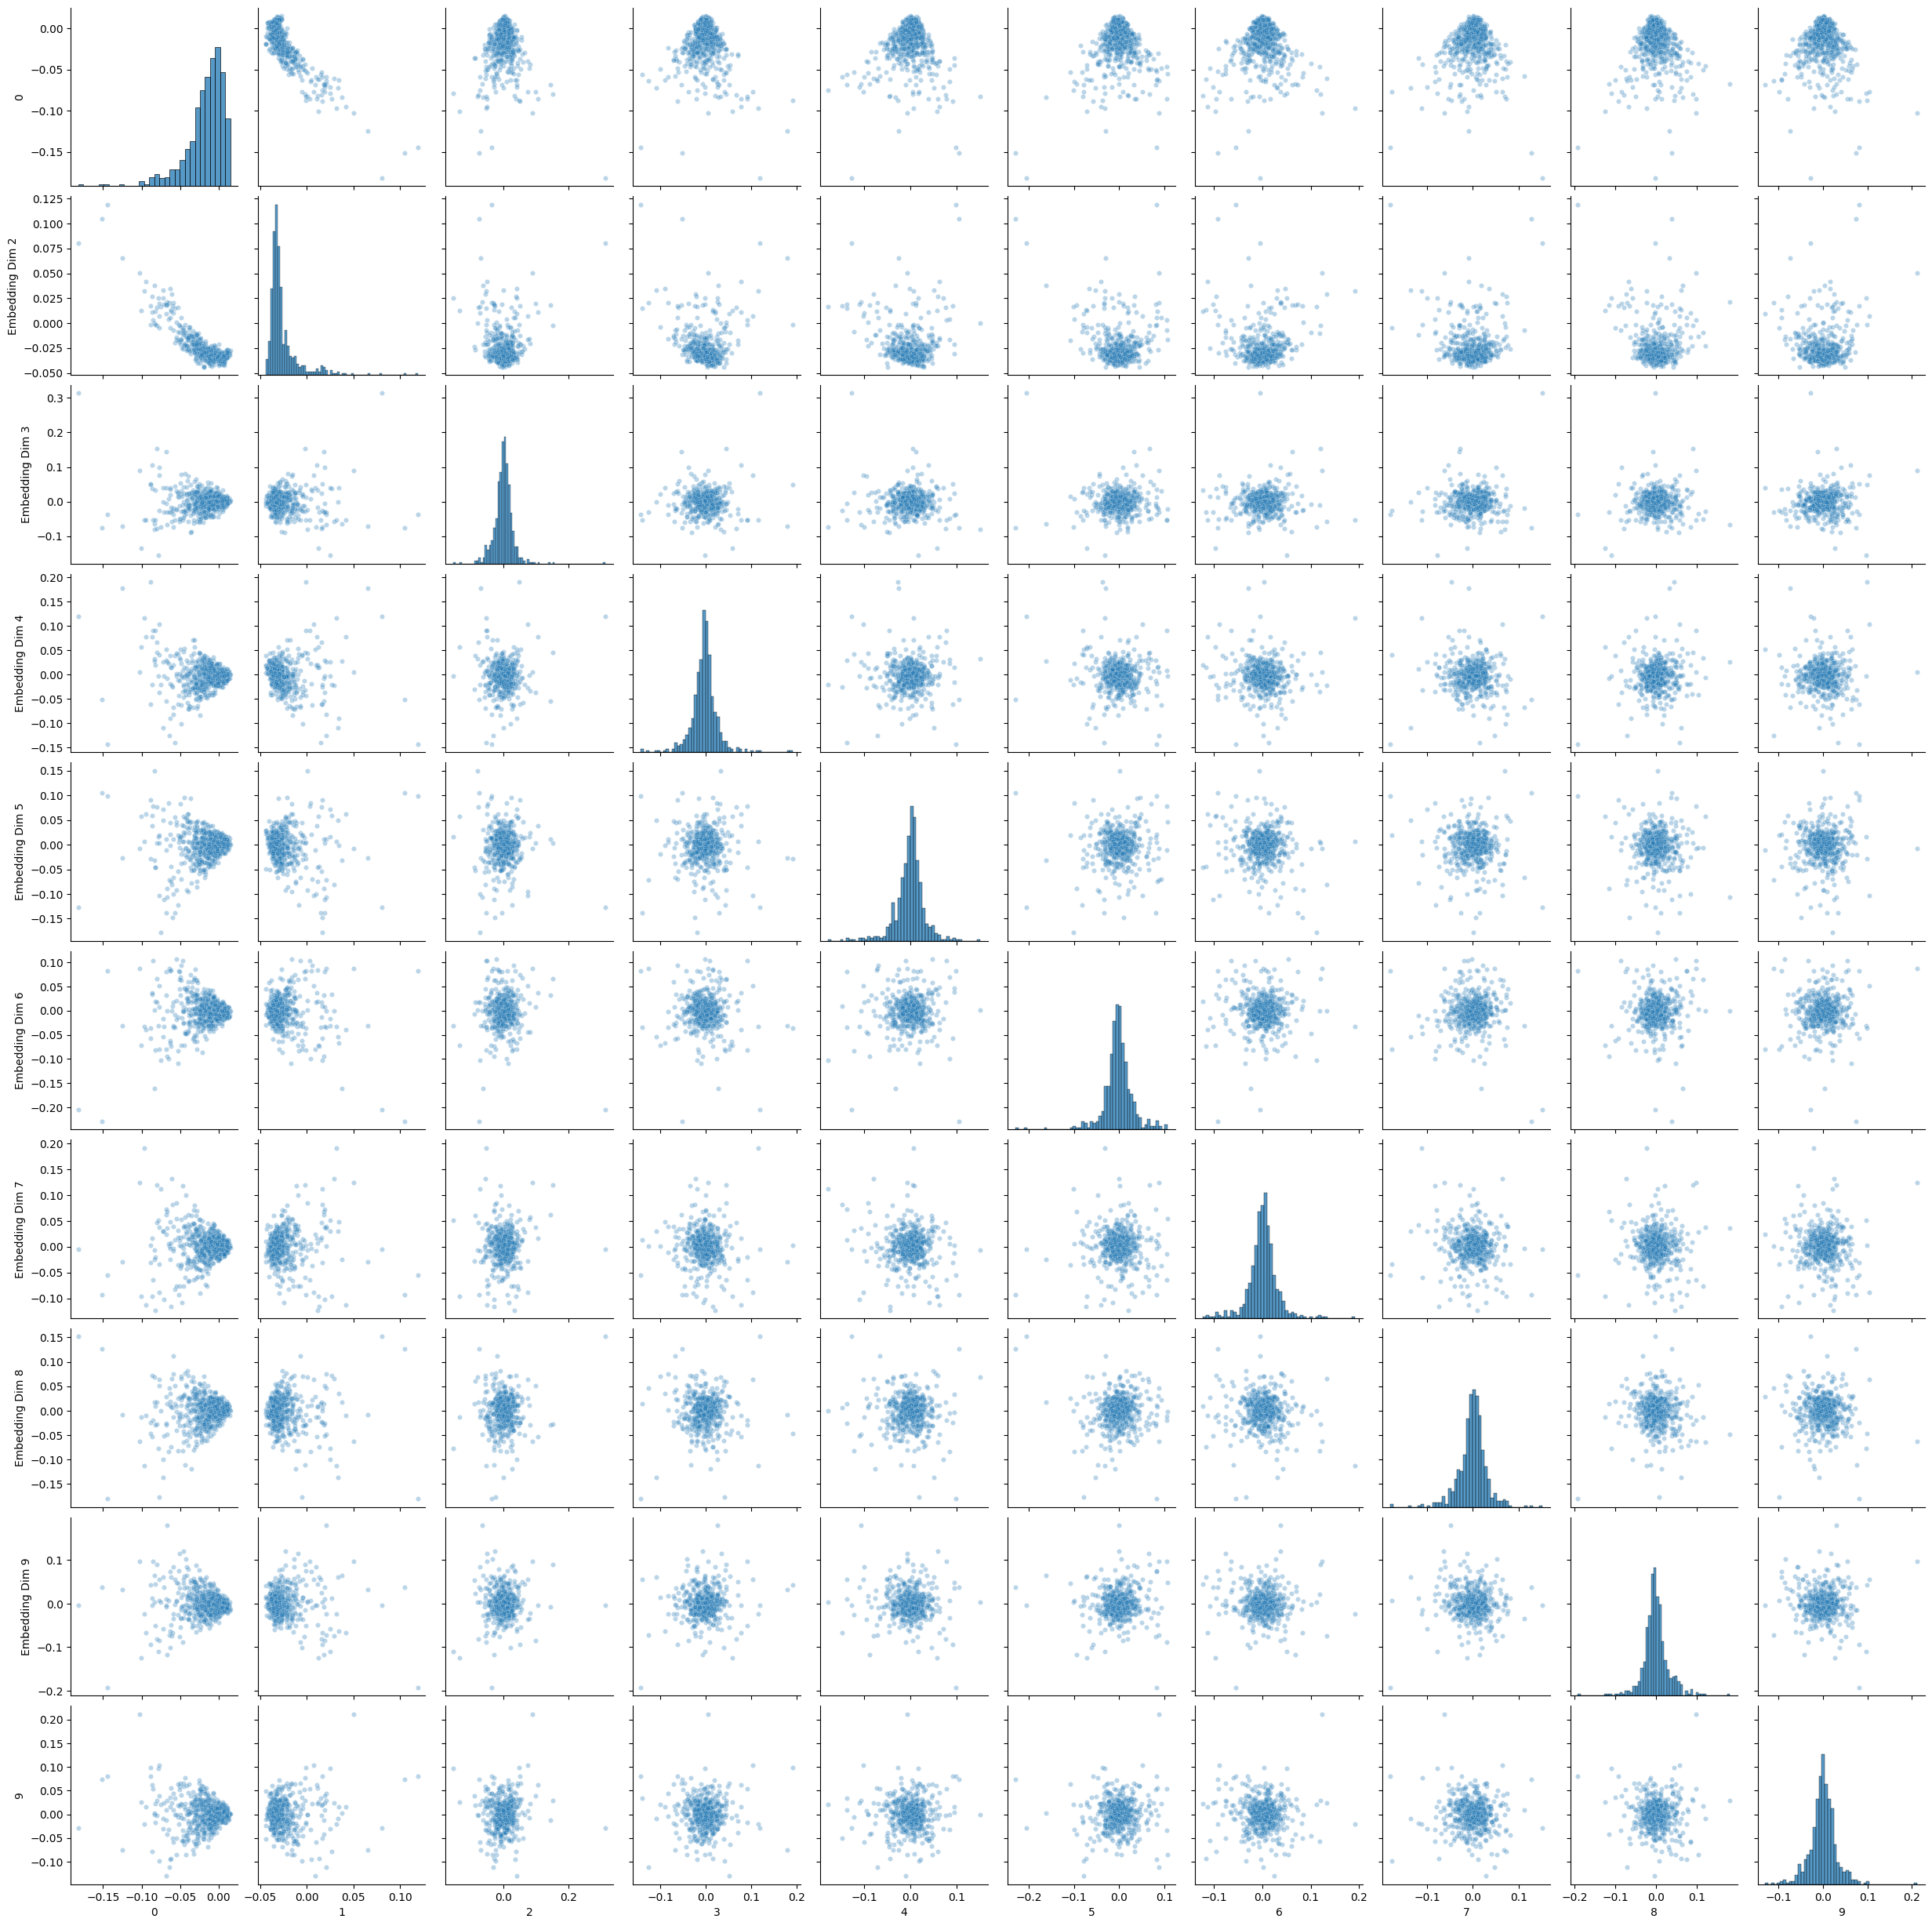

In [14]:
plot_embedding_grid(W0_exact[:,0:10], title_prefix="After nuclear init", sample_fraction=0.6)

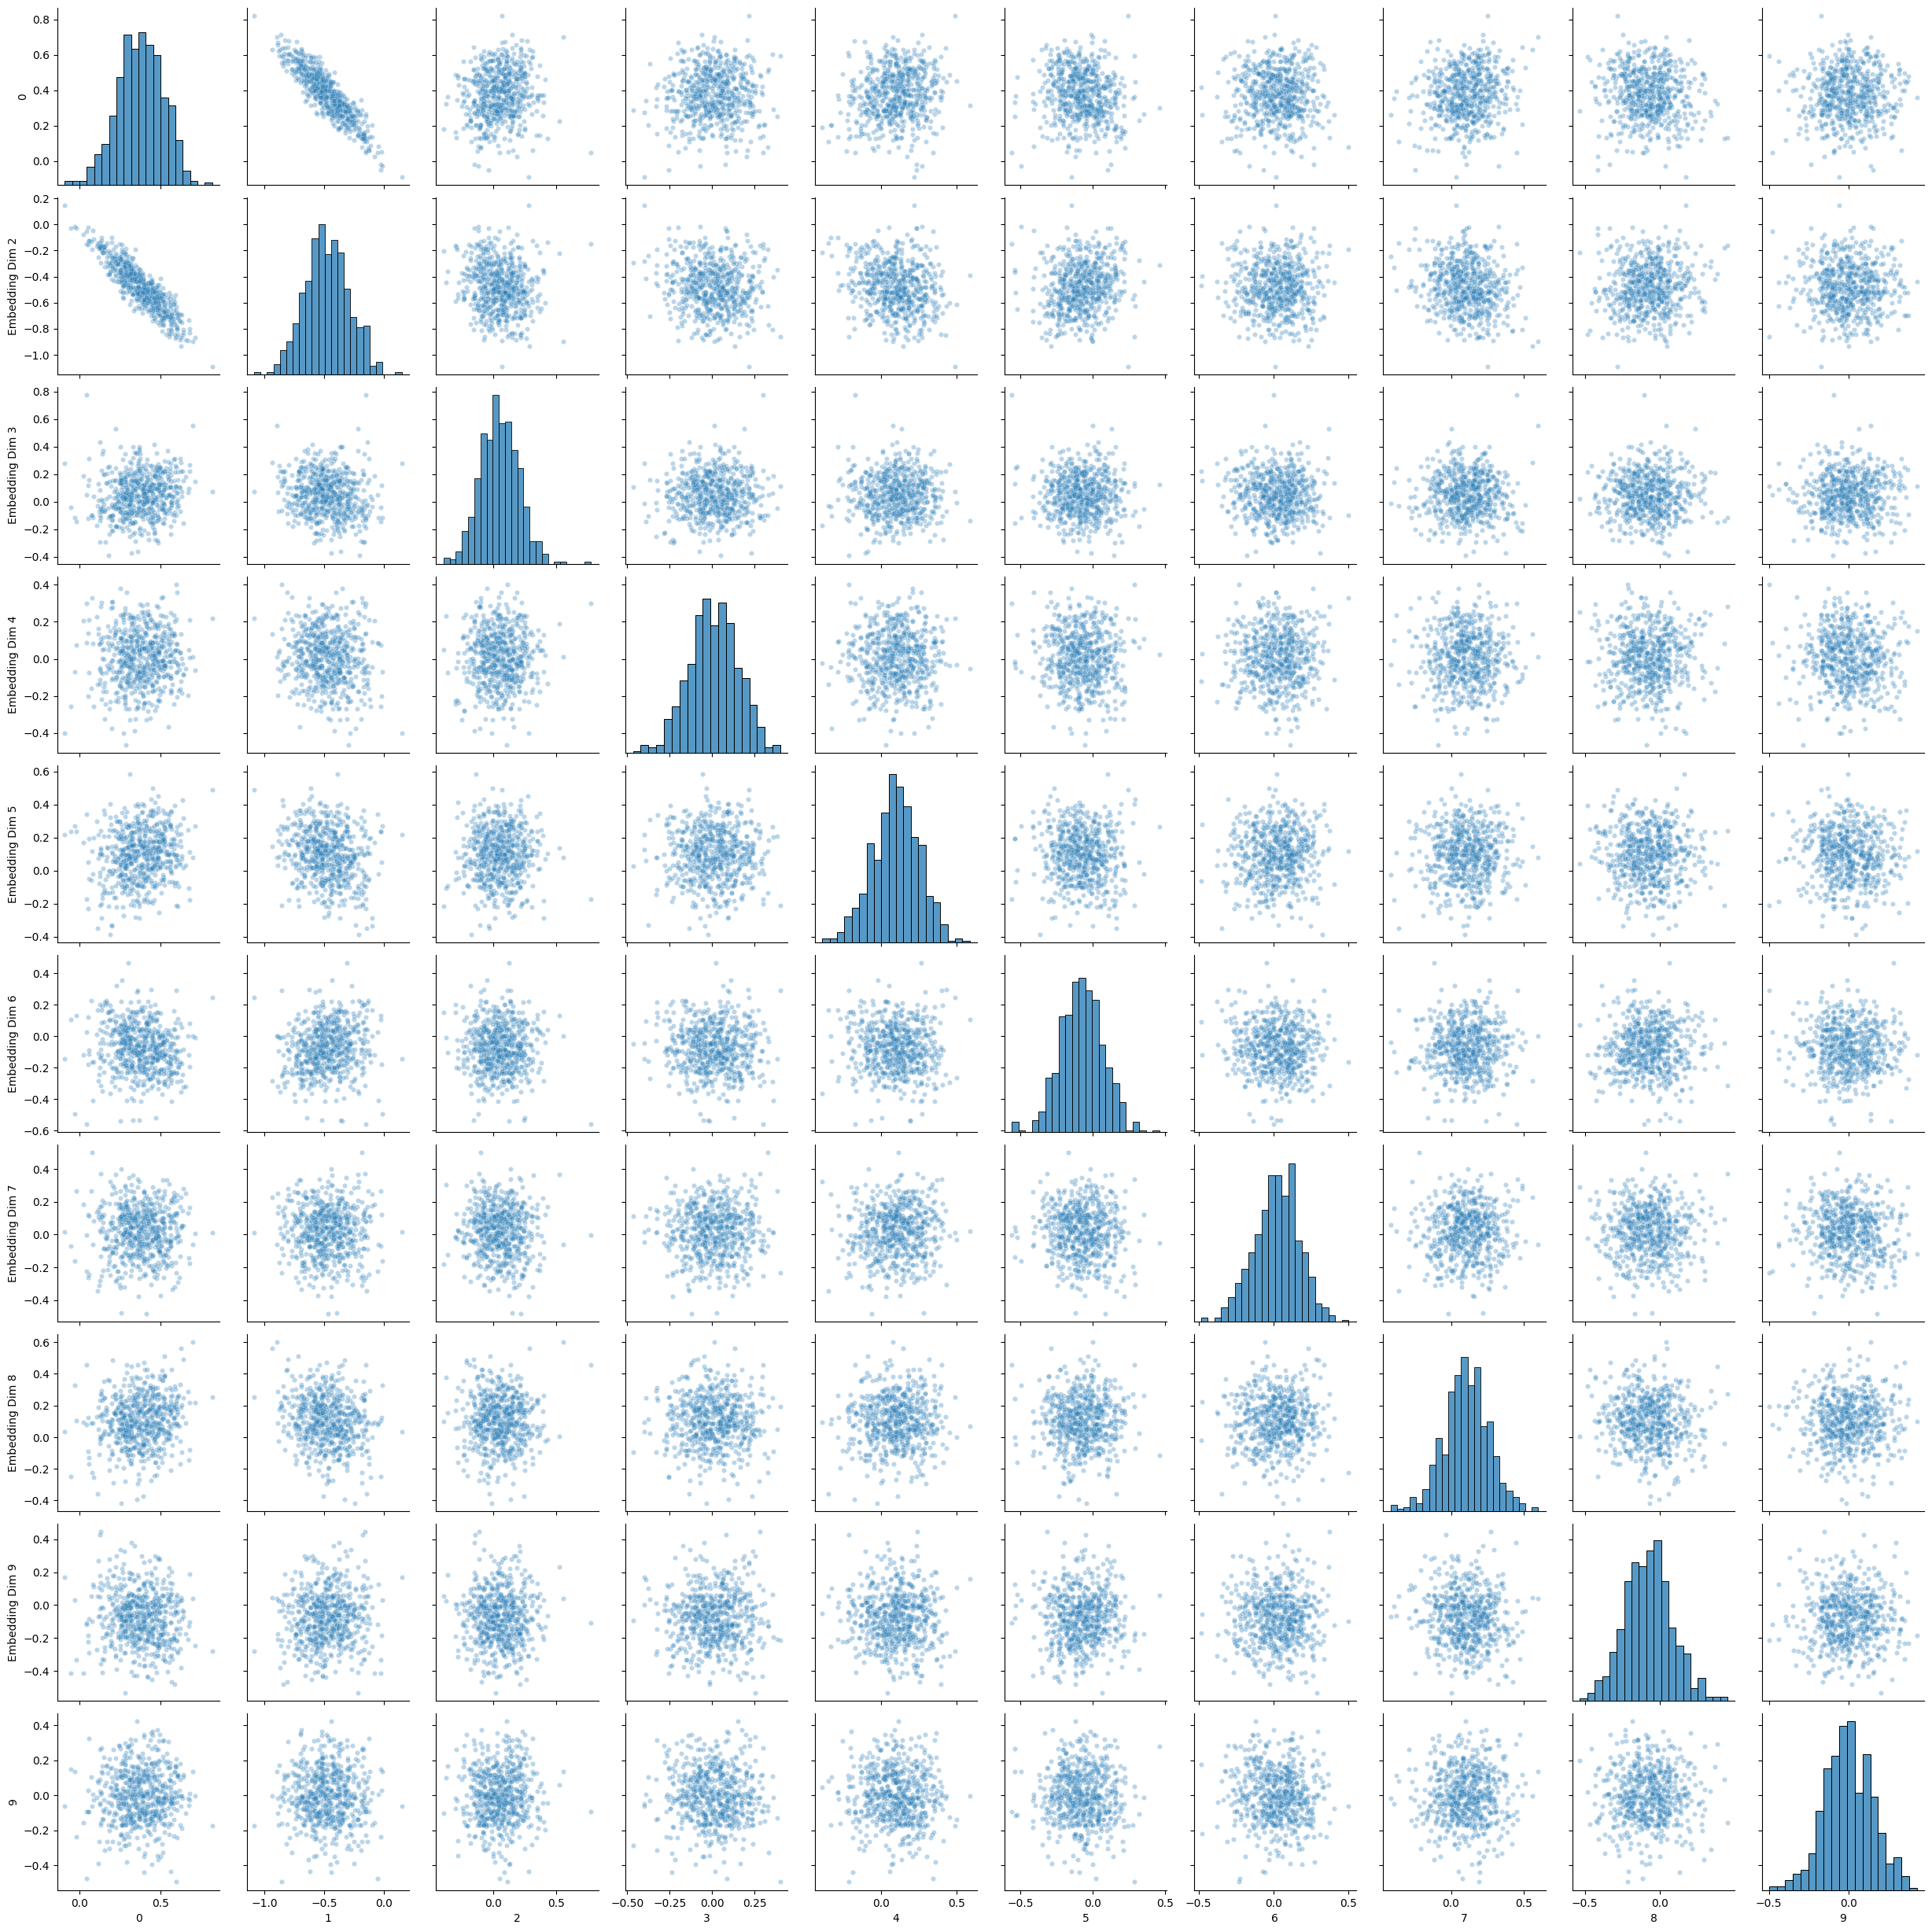

In [15]:
plot_embedding_grid(W_3b_exact[:,0:10], title_prefix="NMD-B (r=6 (correct rank specified), beta=0.9)", sample_fraction=0.6)

## NMD-3B: rank too low

Convergence behavior and original vs. reconstruction plot reminds me of realistic data

In [16]:
k_toolow

10

In [17]:
W0_toolow, H0_toolow = cs.nuclear_norm_init(X, n, p, k_toolow)

In [18]:
Theta_3b_toolow, W_3b_toolow, H_3b_toolow, loss_3b_toolow, iters_3b_toolow, times_3b_toolow = nmd.nmd_3b(X, r=k_toolow, W0=W0_toolow, H0=H0_toolow, beta1=0.7, max_iters=k_toolow*50, tol_over_10iters=10e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 79.171216] - 0.206000 secs
[1 : 78.692084] - 0.208498 secs
[2 : 78.550762] - 0.211390 secs
[3 : 78.562281] - 0.205173 secs
[4 : 78.589275] - 0.208355 secs
[5 : 78.583466] - 0.209039 secs
[6 : 78.562645] - 0.206793 secs
[7 : 78.549054] - 0.208810 secs
[8 : 78.541596] - 0.207600 secs
[9 : 78.538510] - 0.206169 secs
[10 : 78.536860] - 0.209412 secs
[11 : 78.533121] - 0.208422 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.001

Final relative error: 78.52881591589814%, after 13 iterations.
Initialization time: 0.147307 secs
Mean time per iteration: 0.203316 secs
Total time: 2.790415 secs



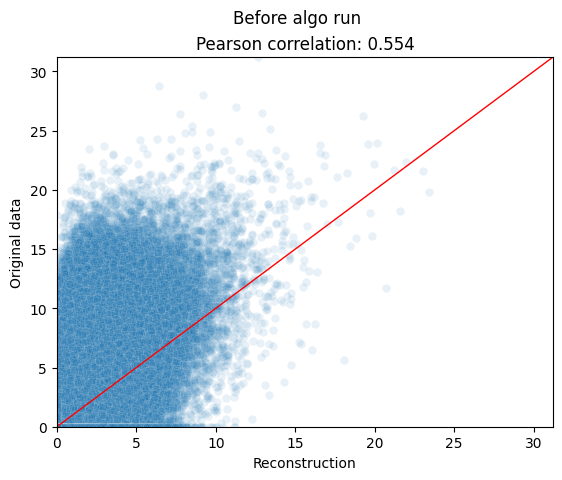

In [19]:
nmd_plot.plot_reconstruction(np.maximum(0, W0_toolow@H0_toolow), X, "Before algo run", type="scatter", sample_fraction=None)

In [20]:
kendalltau(np.maximum(0, W0_toolow@H0_toolow).flatten().round(0), X.flatten())

SignificanceResult(statistic=0.4353683807985947, pvalue=0.0)

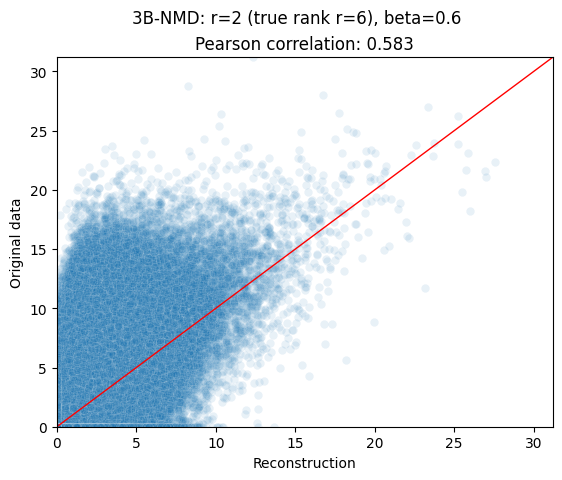

In [21]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b_toolow), X, "3B-NMD: r=2 (true rank r=6), beta=0.6", type="scatter", sample_fraction=None)

In [22]:
kendalltau(np.maximum(0, Theta_3b_toolow).flatten().round(0), X.flatten())

SignificanceResult(statistic=0.4437333306247209, pvalue=0.0)

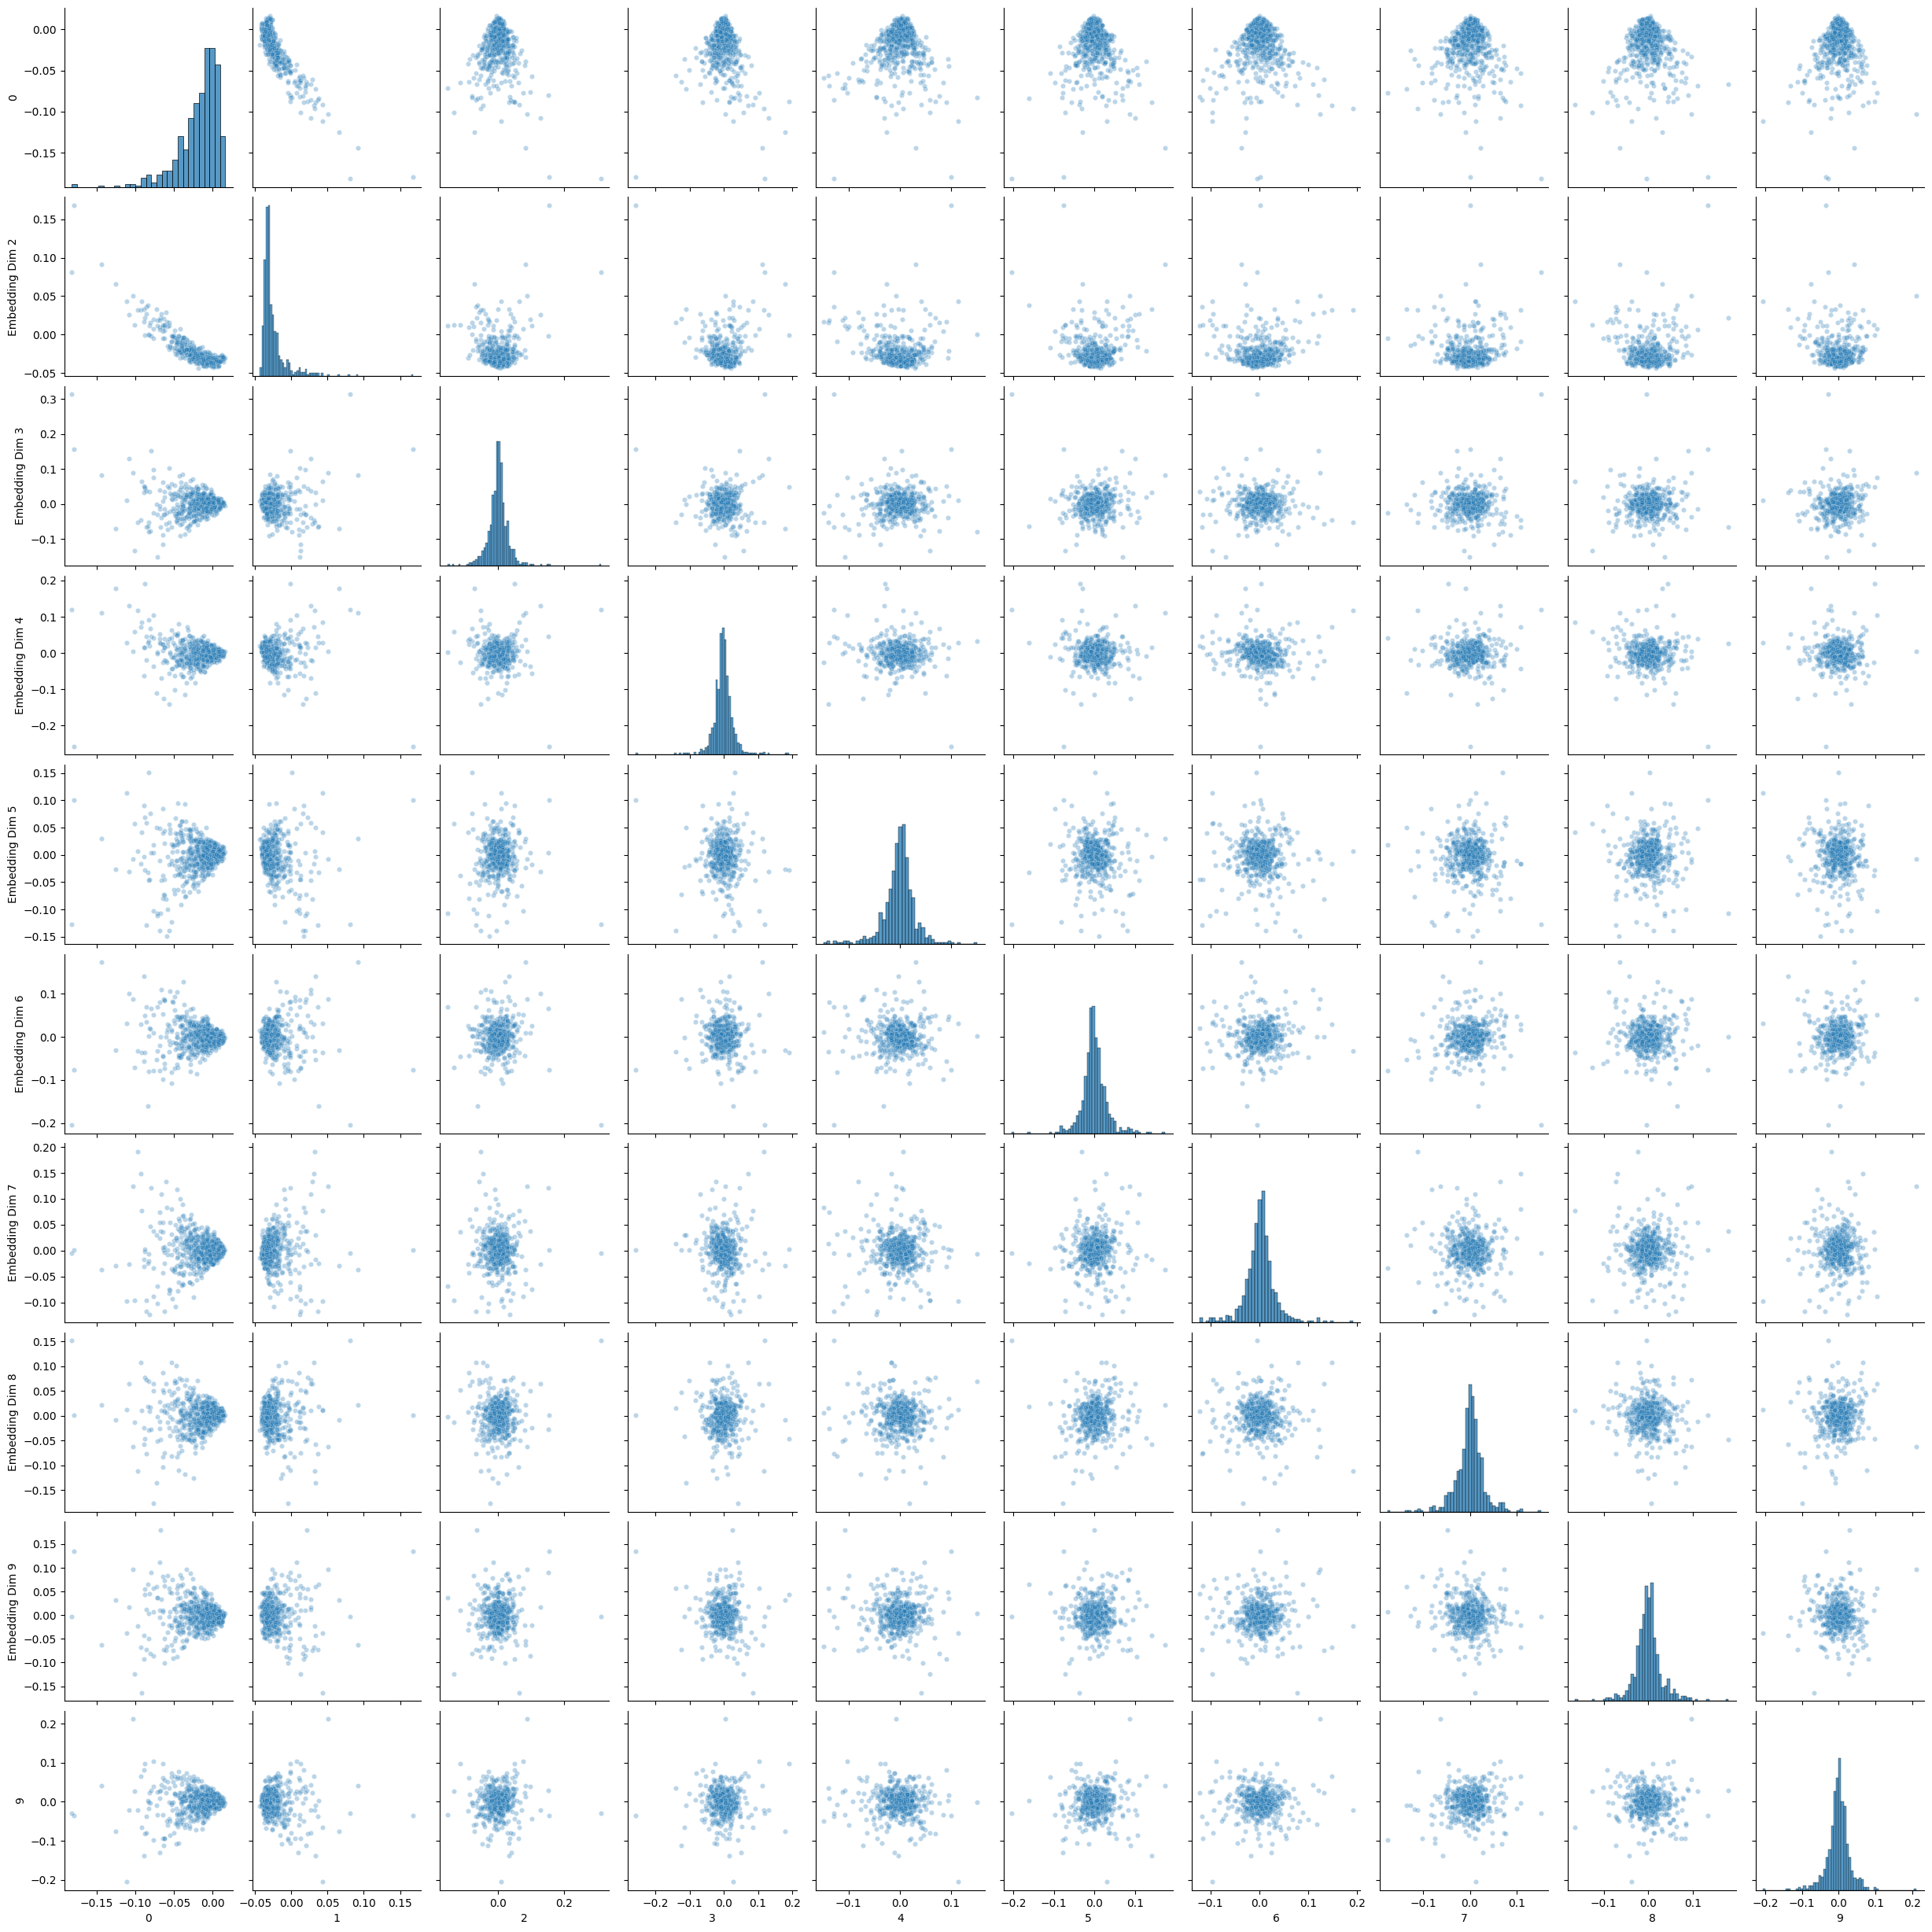

In [23]:
plot_embedding_grid(W0_toolow, title_prefix="After nuclear init (rank misspecified, r_true=6, r=2)", sample_fraction=0.6)

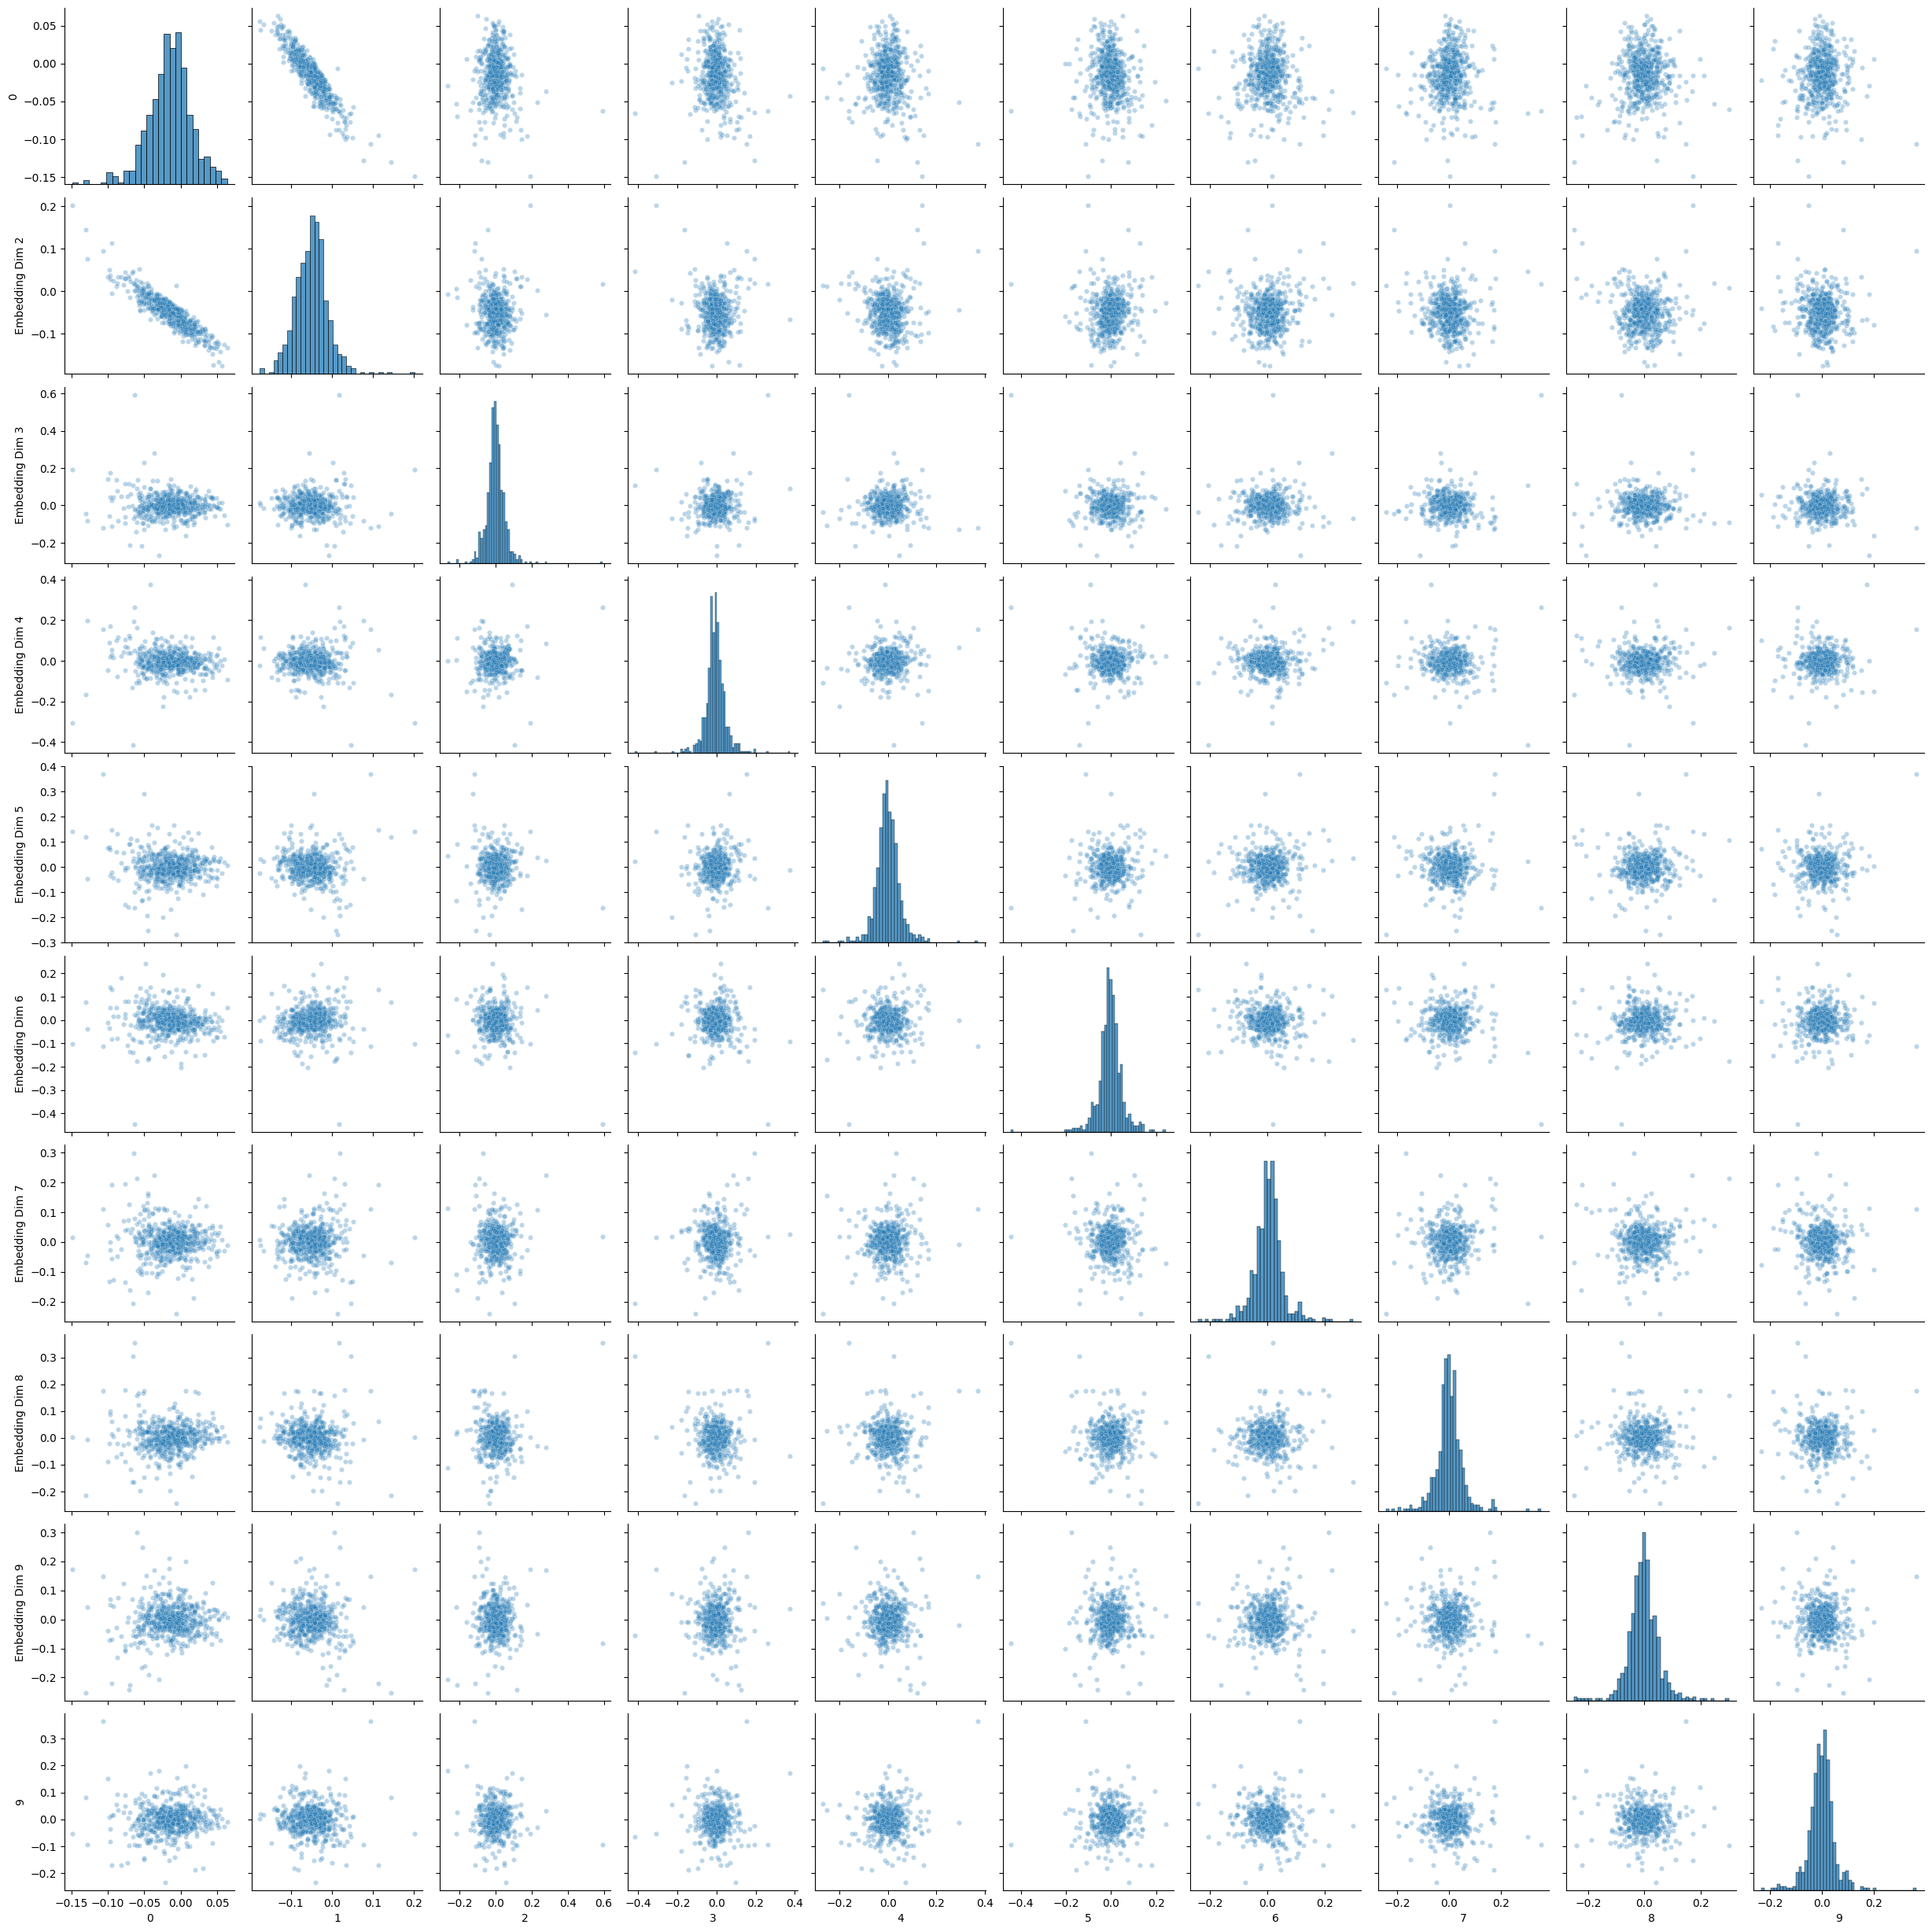

In [24]:
plot_embedding_grid(W_3b_toolow, title_prefix="NMD-3B (rank misspecified, r_true=6, r=2)", sample_fraction=0.6)

## NMD-3B: rank way too low

In [26]:
k_waytoolow

3

In [25]:
W0_waytoolow, H0_waytoolow = cs.nuclear_norm_init(X, n, p, k_waytoolow)

In [27]:
Theta_3b_waytoolow, W_3b_waytoolow, H_3b_waytoolow, loss_3b_waytoolow, iters_3b_waytoolow, times_3b_waytoolow = nmd.nmd_3b(X, r=k_waytoolow, W0=W0_waytoolow, H0=H0_waytoolow, beta1=0.7, max_iters=k_waytoolow*100, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 89.007585] - 0.207926 secs
[1 : 88.917637] - 0.211640 secs
[2 : 88.915504] - 0.209945 secs
[3 : 88.905452] - 0.208242 secs
[4 : 88.863861] - 0.205159 secs
[5 : 88.819860] - 0.206298 secs
[6 : 88.785624] - 0.206756 secs
[7 : 88.756876] - 0.209964 secs
[8 : 88.730930] - 0.206829 secs
[9 : 88.708690] - 0.208982 secs
[10 : 88.688950] - 0.207488 secs
[11 : 88.672115] - 0.207748 secs
[12 : 88.658009] - 0.206550 secs
[13 : 88.646297] - 0.205036 secs
[14 : 88.637003] - 0.203505 secs
[15 : 88.629801] - 0.205038 secs
[16 : 88.624542] - 0.207356 secs
[17 : 88.620955] - 0.206850 secs
[18 : 88.618611] - 0.206231 secs
[19 : 88.617022] - 0.207103 secs
[20 : 88.615888] - 0.207842 secs
[21 : 88.615031] - 0.207553 secs
[22 : 88.614302] - 0.207304 secs
[23 : 88.613633] - 0.206924 secs
[24 : 88.612994] - 0.206293 secs
[25 : 88.612377] - 0.204657 secs
[26 : 88.611786] - 0.206473 secs

Converged: abs(rel. err.(i)

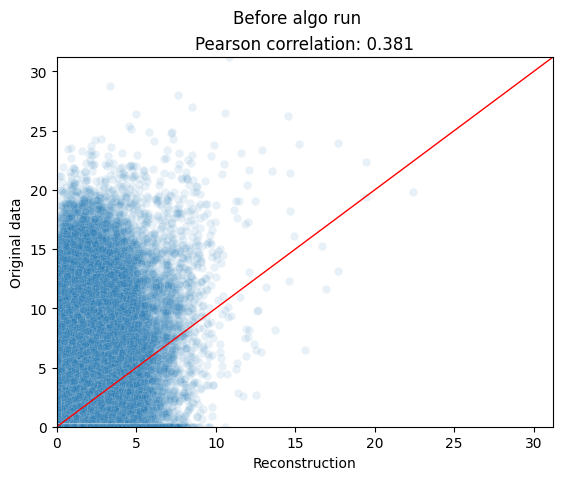

In [28]:
nmd_plot.plot_reconstruction(np.maximum(0, W0_waytoolow@H0_waytoolow), X, "Before algo run", type="scatter", sample_fraction=None)

In [29]:
kendalltau(np.maximum(0, W0_waytoolow@H0_waytoolow).flatten().round(0), X.flatten())

SignificanceResult(statistic=0.30807143529477904, pvalue=0.0)

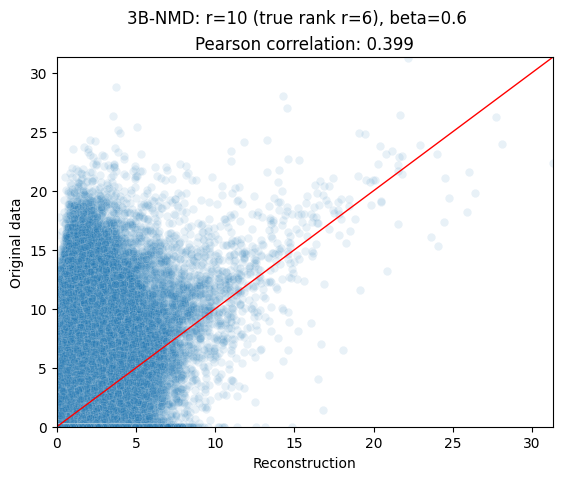

In [30]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b_waytoolow), X, "3B-NMD: r=10 (true rank r=6), beta=0.6", type="scatter", sample_fraction=None)

In [31]:
kendalltau(np.maximum(0, Theta_3b_waytoolow).flatten().round(0), X.flatten())

SignificanceResult(statistic=0.325219454776625, pvalue=0.0)

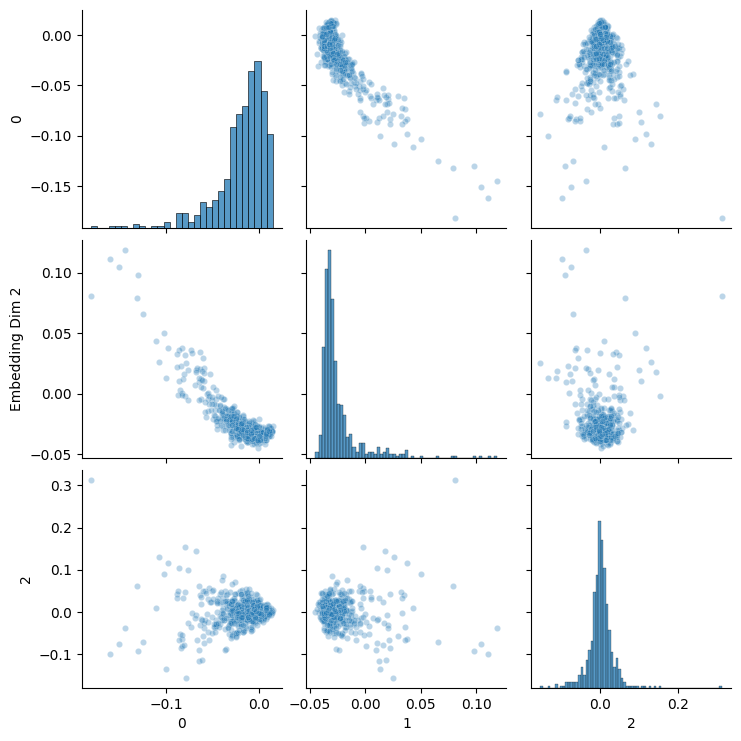

In [32]:
plot_embedding_grid(W0_waytoolow, title_prefix="After nuclear init (rank misspecified, r_true=6, r=10)", sample_fraction=0.6)

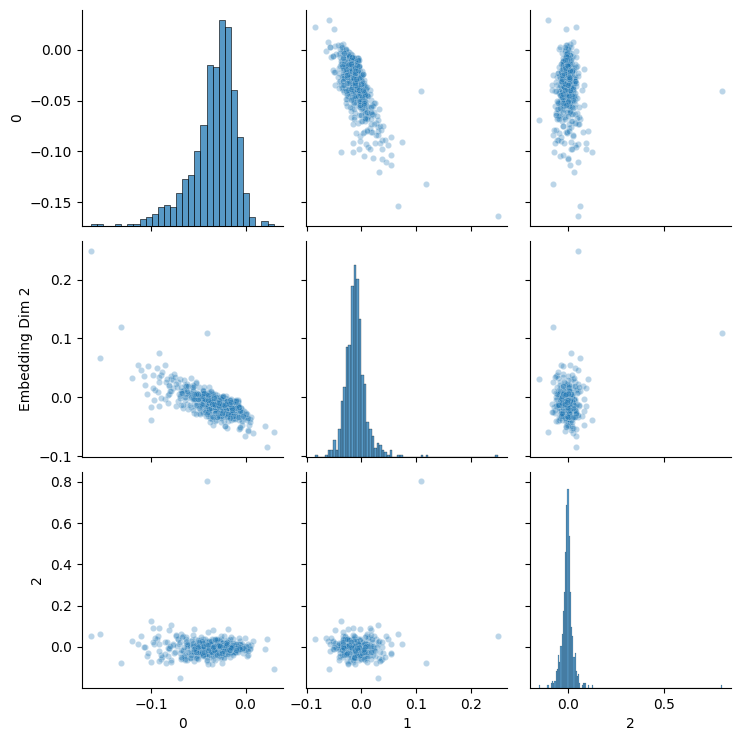

In [33]:
plot_embedding_grid(W_3b_waytoolow, title_prefix="NMD-3B (rank misspecified, r_true=6, r=10)", sample_fraction=0.6)